In [1]:
import pandas as pd 
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import requests
from IPython.display import display, Markdown
from random import sample
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt
import math
from matplotlib_venn import venn2, venn3
from supervenn import supervenn

# Benchmarking L1000 Consensus Signature Methods

This notebook provides code and visualizations for benchmarking different methods of generating consensus signatures from the L1000 signatures. 

The current implementation examines the performance of consensus signatures generated by taking the mean, median, and weighted average of L1000 Characteristic Direction signatures downloaded from SigCom LINCS; however, this notebook is designed to work with any number of consensus and signature computation methods. 

In [2]:
means = pd.read_csv('similarity_matrices/mean_pearson.txt.gz', sep='\t', index_col=0)
medians = pd.read_csv('similarity_matrices/median_pearson.txt.gz', sep='\t', index_col=0)
wavgs = pd.read_csv('similarity_matrices/weightedavg_pearson.txt.gz', sep='\t', index_col=0)

## Extract Consensus Signature Similarity Matrices
For each consensus signature generation method, we generated consensus signatures for all L1000 CRISPR KO genes and chemical perturbations. We then pre-computed the Pearson Correlation Coefficients between each CRISPR KO signature and each chemical perturbation signature. 

The reasoning is that we expect the consensus siganture for a given drug to have a non-random correlation to the consensus CRISPR KO signatures for its targets, representing a common pharmacological effect across different cell line contexts. 

In [3]:
display(Markdown("Pearson Correlation Coefficients for Mean Consensus Signatures"))
display(means)
display(Markdown("Pearson Correlation Coefficients for Median Consensus Signatures"))
display(medians)
display(Markdown("Pearson Correlation Coefficients for Weighted Average Consensus Signatures"))
display(wavgs)

Pearson Correlation Coefficients for Mean Consensus Signatures

,AKT1,KRAS-2B,BRAF1,BRAF,MYC,BRD4,MCL1,CDK4,BCL2L2,MAPK1,...,BRDN0003677177,KIT,SUV420H1,TGFBR2,STAG2,SMC1A,SMC3,RAD21,NIPBL,PDS5B
afatinib,0.039288,0.087599,0.052460,0.032641,0.035939,-0.025099,0.078779,-0.097733,-0.041715,0.158596,...,-0.002491,0.042092,0.017690,0.065971,-0.018110,-0.025007,-0.052941,0.069486,0.015613,0.017151
erlotinib,-0.048258,0.151482,0.064425,0.070239,0.023104,-0.088843,0.093194,-0.155576,-0.023462,0.156218,...,0.003109,-0.004992,0.016802,0.035774,0.012185,-0.030883,0.022719,0.058391,-0.038472,-0.020328
neratinib,-0.011519,0.116096,0.040359,0.142860,0.078508,-0.008306,0.020023,0.050044,-0.008112,0.098631,...,0.036109,0.012717,0.047148,0.063692,0.006152,-0.044527,-0.061279,-0.005293,0.047986,0.039911
lapatinib,-0.039902,0.088429,0.025822,-0.064870,0.025288,-0.023845,-0.065937,-0.203769,-0.046839,0.103114,...,-0.068757,-0.055504,0.081767,0.159499,0.063188,-0.008917,-0.013766,-0.073146,-0.032068,0.078218
pazopanib,-0.115736,-0.041087,-0.118093,-0.012833,-0.101394,-0.125349,0.088811,-0.107420,0.022588,-0.083674,...,0.029134,-0.076045,-0.013759,0.112378,-0.040245,-0.020721,-0.001347,0.060826,-0.008466,0.015619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
desvenlafaxine,-0.057500,0.009144,-0.066686,0.003290,-0.030215,-0.072164,-0.003146,-0.197048,-0.072740,0.045427,...,0.007904,0.034718,0.037131,0.015089,0.000156,0.033563,0.094683,-0.032039,-0.065282,-0.019728
taltirelin,-0.042235,0.012455,-0.056294,-0.071240,-0.068729,0.006262,-0.007184,-0.146936,0.024411,-0.011845,...,-0.023191,0.027566,0.020941,0.041642,0.006416,0.015843,0.018180,0.071191,-0.130223,0.043829
rupatadine,-0.022242,0.049211,0.023811,-0.114862,0.048122,0.022194,-0.085811,-0.142641,-0.163349,0.033877,...,-0.017072,0.130603,-0.108800,-0.105444,0.034300,-0.143470,-0.031385,-0.017706,0.077739,0.066941
talinolol,-0.049888,-0.001736,-0.074130,-0.082681,-0.020887,0.012472,-0.103481,-0.076028,0.104234,-0.035430,...,-0.001946,0.048554,-0.040367,0.193269,0.006213,-0.077561,-0.123392,0.098631,0.028672,0.081624


Pearson Correlation Coefficients for Median Consensus Signatures

,AKT1,KRAS-2B,BRAF1,BRAF,MYC,BRD4,MCL1,CDK4,BCL2L2,MAPK1,...,BRDN0003677177,KIT,SUV420H1,TGFBR2,STAG2,SMC1A,SMC3,RAD21,NIPBL,PDS5B
afatinib,0.051767,0.133398,0.080351,0.063201,0.107135,0.018604,0.112896,-0.073323,0.004723,0.157686,...,0.006165,0.044201,0.035481,0.104882,-0.057247,-0.010636,0.033024,0.081134,0.005840,-0.010548
erlotinib,0.002502,0.176474,0.071451,0.105725,0.075541,-0.044170,0.102680,-0.130693,0.022231,0.126003,...,0.012645,-0.011169,0.051464,0.091472,-0.026796,-0.022035,0.092110,0.076800,-0.046434,-0.045664
neratinib,0.009636,0.154788,0.055518,0.158173,0.134390,0.026031,0.063275,0.065081,-0.003457,0.134173,...,0.043940,0.009929,0.058189,0.085934,-0.014226,-0.058900,-0.009731,0.023470,0.042463,0.021765
lapatinib,0.025341,0.094168,0.030544,-0.066402,0.056962,0.025915,0.009600,-0.180667,0.028163,0.097402,...,-0.025873,-0.045500,0.071522,0.216329,0.020691,-0.006198,0.081951,-0.032450,-0.028261,-0.006342
pazopanib,-0.076459,0.026644,-0.091446,0.038801,-0.049903,-0.090547,0.103126,-0.108055,0.177348,-0.036792,...,0.026215,-0.064031,-0.022605,0.171841,-0.041509,0.012598,0.030378,0.055902,-0.020205,0.015649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
desvenlafaxine,0.035313,0.074652,-0.049751,-0.003208,0.005777,-0.042920,0.061258,-0.153651,0.054393,0.055375,...,0.049694,0.029920,0.050870,0.078416,-0.020032,0.033176,0.130389,-0.019806,-0.008313,-0.022432
taltirelin,0.022628,0.056814,0.019259,0.006777,-0.005549,0.044637,-0.015711,-0.105024,0.110464,0.024544,...,-0.006071,0.035309,0.072777,0.108833,-0.015532,0.066210,0.127457,0.037998,-0.103694,-0.061299
rupatadine,0.017681,0.051315,0.040323,-0.085913,0.072831,-0.009402,-0.066040,-0.147568,-0.081792,0.065457,...,0.011651,0.128499,-0.124422,-0.070918,0.035924,-0.099524,0.033638,-0.026681,0.044997,0.044457
talinolol,-0.043222,0.027401,0.004059,-0.003828,-0.024398,0.045217,-0.013021,-0.010395,0.168474,-0.038179,...,0.078951,-0.011128,0.068661,0.237796,-0.010255,-0.018282,0.021292,0.018570,0.018735,-0.009164


Pearson Correlation Coefficients for Weighted Average Consensus Signatures

,AKT1,KRAS-2B,BRAF1,BRAF,MYC,BRD4,MCL1,CDK4,BCL2L2,MAPK1,...,BRDN0003677177,KIT,SUV420H1,TGFBR2,STAG2,SMC1A,SMC3,RAD21,NIPBL,PDS5B
afatinib,0.043842,0.126407,0.057370,0.032816,0.029585,-0.028552,0.083929,-0.060740,-0.009248,0.137992,...,0.029999,0.042848,0.012697,0.050618,-0.010374,-0.023753,-0.073939,0.054797,0.041644,0.011173
erlotinib,-0.039662,0.189926,0.074773,0.068886,-0.016643,-0.104045,0.089787,-0.118480,-0.011179,0.151351,...,0.024561,-0.004225,0.017831,0.038363,-0.012422,-0.029911,0.008076,0.060249,-0.008020,-0.023663
neratinib,-0.022374,0.097546,0.053648,0.128124,0.074055,-0.012890,0.045100,0.084469,0.005544,0.066128,...,0.062011,0.014258,0.041622,0.073326,0.010700,-0.054571,-0.081777,-0.008257,0.080846,0.051861
lapatinib,-0.046097,0.110954,0.027357,-0.071855,-0.079702,-0.019023,-0.040734,-0.203612,-0.047021,0.129413,...,-0.078217,-0.047301,0.072616,0.162382,0.071773,-0.021629,-0.022790,-0.072636,-0.011988,0.083381
pazopanib,-0.133967,-0.065964,-0.134439,-0.008608,-0.182686,-0.121940,0.096863,-0.107326,0.055106,-0.109153,...,0.044837,-0.087218,-0.022356,0.109515,-0.007274,-0.021698,-0.019016,0.050318,-0.014645,0.006664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
desvenlafaxine,-0.066152,0.028200,-0.040536,0.003049,-0.084393,-0.069483,-0.014510,-0.205238,-0.077648,0.031597,...,0.012706,0.032006,0.041190,0.017247,-0.000311,0.037844,0.078058,-0.027733,-0.072112,-0.040837
taltirelin,-0.038543,0.019442,-0.049489,-0.088412,-0.120527,0.014203,-0.031268,-0.173947,0.037578,0.005174,...,-0.021278,0.028144,0.015788,0.032516,0.021326,0.009114,0.037747,0.079069,-0.139897,0.030299
rupatadine,-0.017826,0.057744,0.025905,-0.111355,0.091760,-0.000953,-0.107360,-0.104506,-0.193811,0.043774,...,-0.001984,0.140903,-0.125506,-0.087973,0.013074,-0.135349,-0.011436,-0.009831,0.091532,0.052763
talinolol,-0.071532,-0.014545,-0.091004,-0.086301,-0.081596,0.046822,-0.065511,-0.085525,0.107279,-0.034005,...,-0.005736,0.045796,-0.041015,0.182636,0.036970,-0.086812,-0.135329,0.105089,0.016583,0.083552


## Comparison with Known Drug-Target Pairs
### Ranking CRISPR KO consensus signatures by similarity to each drug consensus signature
Because some drugs may have both inhibitory and agonist effects depending on the target, we rank targets for each drug in both ascending (low to high similarity) and descending (high to low similarity) order. 

We expect that for drugs with inhibitory targets, the consensus CRISPR KO signatures for those targets should have high similarity to the drug perturbation signatures. Conversely, the CRISPR KO signatures of agonist targets should have low similarity to the corresponding drug perturbation signature. 

In [50]:
asc_drug_ranks = {'mean': {}, 'median': {}, 'wavg': {}, 'random': {}}
desc_drug_ranks = {'mean': {}, 'median': {}, 'wavg': {}, 'random': {}}
for drug in means.index: 
    asc_drug_ranks['mean'][drug] = means.loc[drug].sort_values(ascending=True).index.tolist()
    asc_drug_ranks['median'][drug] = medians.loc[drug].sort_values(ascending=True).index.tolist()
    asc_drug_ranks['wavg'][drug] = wavgs.loc[drug].sort_values(ascending=True).index.tolist()
    asc_drug_ranks['random'][drug] = sample(means.columns.tolist(), len(means.columns))

    desc_drug_ranks['mean'][drug] = means.loc[drug].sort_values(ascending=False).index.tolist()
    desc_drug_ranks['median'][drug] = medians.loc[drug].sort_values(ascending=False).index.tolist()
    desc_drug_ranks['wavg'][drug] = wavgs.loc[drug].sort_values(ascending=False).index.tolist()
    desc_drug_ranks['random'][drug] = sample(means.columns.tolist(), len(means.columns))


### Extraction of drug-target associations from Pharos
Using [Pharos](https://pharos.nih.gov/), we pre-constructed a list of drug-target associations by querying all ligands in Pharos, filtering [only to drugs](https://pharos.nih.gov/ligands?facet=Type!Drug) (n=1782), and downloading the table of all associated target symbols for each drug. 

Here, we import the generated table and identify the drugs which overlap with the L1000 chemical perturbations (n=720).


In [5]:
pharos = pd.read_csv('pharos_query_results.csv')
pharos = pharos.dropna(subset=['Ligand Name', 'Symbol'])
pharos = pharos.sort_values(by=['Ligand Action']).drop_duplicates(subset=['Ligand Name', 'Symbol'], keep='first')
pharos_drugs = set(pharos['Ligand Name'].tolist()).intersection(asc_drug_ranks['mean'].keys())
print(len(pharos_drugs), 'drugs overlap')

720 drugs overlap


For each of the overlapping drugs between Pharos and the L1000 dataset, we can store all targets associated with the drug in a dictionary.

In [51]:
drug2target = {}
drugtarget2action = {}
for d in pharos_drugs:
  if type(pharos[pharos['Ligand Name'] == d]['Symbol']) == str: 
    drug2target[d] = [pharos.loc[d]['Symbol']]
    drugtarget2action[f"{d}-{drug2target[d][0]}"] = pharos.loc[d]['Ligand Action']
  else:
    drug2target[d] = pharos[pharos['Ligand Name'] == d]['Symbol'].tolist()
    for s in drug2target[d]: 
      drugtarget2action[f"{d}-{s}"] = pharos[(pharos['Ligand Name']==d) & (pharos['Symbol']==s)]['Ligand Action'].iloc[0]

In [52]:
asc_rankings = []
desc_rankings = []
for drug in drug2target.keys(): 
  for method in ['mean', 'median', 'wavg', 'random']:
    asc_indices = np.nonzero(np.isin(asc_drug_ranks[method][drug], drug2target[drug]))[0]
    desc_indices = np.nonzero(np.isin(desc_drug_ranks[method][drug], drug2target[drug]))[0]
    for i in range(len(asc_indices)):
      asc_rankings.append([method, drug, asc_indices[i], asc_drug_ranks[method][drug][asc_indices[i]]])
    for i in range(len(desc_indices)):
      desc_rankings.append([method, drug, desc_indices[i], desc_drug_ranks[method][drug][desc_indices[i]]])

In [53]:
asc_rankings_df = pd.DataFrame(
  data=asc_rankings,
  columns=['Method', 'Drug', 'AscRank', 'Target']
)

desc_rankings_df = pd.DataFrame(
  data=desc_rankings,
  columns=['Method', 'Drug', 'DescRank', 'Target']
)

In [54]:
asc_rankings_df['Action'] = asc_rankings_df.apply(
  lambda row: drugtarget2action[f"{row.Drug}-{row.Target}"], axis=1
)
desc_rankings_df['Action'] = desc_rankings_df.apply(
  lambda row: drugtarget2action[f"{row.Drug}-{row.Target}"], axis=1
)

In [55]:
display(desc_rankings_df.groupby(['Method']).mean(numeric_only=True).sort_values(by='DescRank'))

,DescRank
Method,
wavg,3617.909457
mean,3621.042791
median,3635.453333
random,3747.283101


In [56]:
display(desc_rankings_df.groupby(['Method', 'Action']).mean(numeric_only=True).sort_values(by=['Method','DescRank']))

DescRank
Method Action                                    
mean   GATING INHIBITOR                192.000000
       ALLOSTERIC MODULATOR           1306.000000
       POSITIVE ALLOSTERIC MODULATOR  2926.400000
       PARTIAL AGONIST                2944.666667
       ALLOSTERIC ANTAGONIST          3130.166667
       BLOCKER                        3384.564706
       POSITIVE MODULATOR             3468.428571
       AGONIST                        3559.194286
       INHIBITOR                      3687.469602
       ANTAGONIST                     3709.403361
       INVERSE AGONIST                4158.142857
       MODULATOR                      4555.500000
       ACTIVATOR                      4717.500000
       OPENER                         4776.500000
       NEGATIVE ALLOSTERIC MODULATOR  5743.250000
median GATING INHIBITOR                377.666667
       ALLOSTERIC MODULATOR            435.000000
       POSITIVE ALLOSTERIC MODULATOR  2313.857143
       PARTIAL AGONIST                2572.266667
       ALLOSTERIC ANTAGONIST          2697.166667
       POSITIVE MODULATOR             3123.285714
       BLOCKER                        3481.752941
       AGONIST                        3564.691429
       INHIBITOR                      3717.691824
       INVERSE AGONIST                3747.714286
       ANTAGONIST                     3828.865546
       MODULATOR                      4457.500000
       OPENER                         4576.000000
       ACTIVATOR                      4732.750000
       NEGATIVE ALLOSTERIC MODULATOR  5739.500000
random ALLOSTERIC MODULATOR           1141.000000
       GATING INHIBITOR               2741.000000
       POSITIVE MODULATOR             3145.285714
       PARTIAL AGONIST                3453.600000
       ACTIVATOR                      3552.000000
       ANTAGONIST                     3634.205882
       BLOCKER                        3673.764706
       AGONIST                        3738.171429
       NEGATIVE ALLOSTERIC MODULATOR  3770.250000
       INHIBITOR                      3778.750524
       INVERSE AGONIST                3897.285714
       POSITIVE ALLOSTERIC MODULATOR  3944.057143
       MODULATOR                      4212.250000
       ALLOSTERIC ANTAGONIST          5198.166667
       OPENER                         6083.500000
wavg   GATING INHIBITOR                249.333333
       ALLOSTERIC MODULATOR           1350.000000
       POSITIVE ALLOSTERIC MODULATOR  2888.485714
       PARTIAL AGONIST                2956.133333
       ALLOSTERIC ANTAGONIST          3003.500000
       AGONIST                        3478.800000
       BLOCKER                        3519.447059
       INHIBITOR                      3677.138365
       POSITIVE MODULATOR             3680.714286
       ANTAGONIST                     3708.424370
       INVERSE AGONIST                4402.000000
       OPENER                         4512.000000
       ACTIVATOR                      4548.625000
       MODULATOR                      4708.250000
       NEGATIVE ALLOSTERIC MODULATOR  5761.000000

## Boxplot

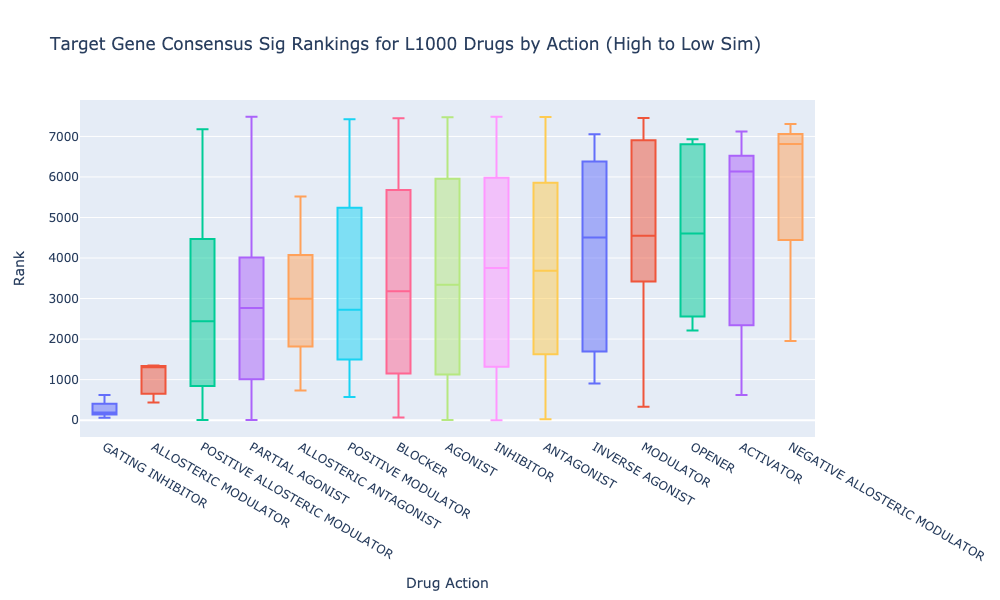

In [12]:
method_color_map = {}
fig1 = go.Figure()

desc_sub_df = desc_rankings_df[asc_rankings_df['Method'] != 'random'].set_index('Action')
for gs in desc_sub_df.groupby(['Action']).mean(numeric_only=True).sort_values('DescRank').index:
    fig1.add_trace(
        go.Box(
            y=desc_sub_df.loc[gs,'DescRank'].tolist(),
            name=gs
        )
    )
fig1.update_xaxes(title_text="Drug Action")
fig1.update_yaxes(title_text="Rank")

fig1.update_layout(
    height=600,
    width=1000,
    title_text="Target Gene Consensus Sig Rankings for L1000 Drugs by Action (High to Low Sim)",
    showlegend=False
)
fig1.show("png")

## Bridge Plots

In [57]:
inh_drug2target = {}
agon_drug2target = {}
for k in drugtarget2action.keys(): 
  if drugtarget2action[k] == 'INHIBITOR': 
    if k in inh_drug2target.keys(): 
      inh_drug2target[k.split('-')[0]].append(k.split('-')[1])
    else:
      inh_drug2target[k.split('-')[0]] = [k.split('-')[1]]
  elif drugtarget2action[k] == 'AGONIST': 
    if k in agon_drug2target.keys(): 
      agon_drug2target[k.split('-')[0]].append(k.split('-')[1])
    else:
      agon_drug2target[k.split('-')[0]] = [k.split('-')[1]]
  else: 
    continue

In [68]:
color_dict = {
  'mean': '#88CCEE',
  'median': '#DDCC77',
  'wavg': '#CC6677'
}

def drugBridgePlot(drug, method, ranks, dtmapping): 
  select = pd.Series([x.upper() in dtmapping[drug] for x in ranks[method][drug]])
  x, y = bridge_plot(select)
  return x/len(x), y 

def methodBridgePlot(method, ranks, dtmapping): 
  x = []
  y = []
  for drug in ranks[method].keys(): 
    if drug in dtmapping.keys():
      x_drug, y_drug = drugBridgePlot(drug, method, ranks, dtmapping)
      x.append(x_drug)
      y.append(y_drug)
  return np.nanmean(np.array(x), axis=0), np.nanmean(np.array(y), axis=0)

def fullBridgePlot(ranks, sim, dtmapping):
  fig = plt.figure()
  for method in ranks.keys(): 
    x_method, y_method = methodBridgePlot(method, ranks, dtmapping)
    if method == 'random': 
      plt.plot(x_method, y_method, label=method, color='gray')
    else:
      plt.plot(x_method, y_method, label=method, color=color_dict[method])
  plt.axhline(y=0, color='black', linestyle='dashed')
  plt.xlabel('Rank')
  plt.ylabel('D(r) - r')
  plt.legend(bbox_to_anchor=(1.25,1))
  # plt.title(f"Target Gene Consensus CRISPR KO Sig Ranks for L1000 Drugs ({sim})")
  plt.show()
  fig.savefig('../../publicationfigs/Figure7B.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [69]:
def leadingEdge(ranks, drugtype, dtmapping, cutoff=0.01): 
  fig = plt.figure()
  for method in ranks.keys(): 
    x_method, y_method = methodBridgePlot(method, ranks, dtmapping)
    x_method = x_method[x_method < cutoff]
    y_method = y_method[:len(x_method)]
    if method == 'random': 
      plt.plot(x_method, y_method, label=method, color='gray')
    else:
      plt.plot(x_method, y_method, label=method, color=color_dict[method])
  plt.axhline(y=0, color='black', linestyle='dashed')
  plt.xlabel('Rank')
  plt.ylabel('D(r) - r')
  plt.legend(bbox_to_anchor=(1.3,1))
  # plt.title(f"Leading Edge of Target Gene Consensus CRISPR KO Sig Ranks ({drugtype})")
  plt.show()
  fig.savefig('../../publicationfigs/Figure7A.pdf', format='pdf', dpi=300, bbox_inches='tight')

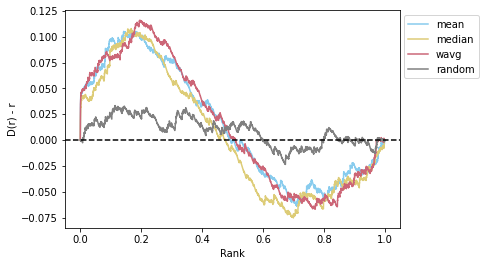

In [70]:
inhibitors = desc_rankings_df[desc_rankings_df['Action'] == 'INHIBITOR']['Drug'].tolist()
inh_desc_drug_ranks = {
  m: {d: desc_drug_ranks[m][d] for d in desc_drug_ranks[m].keys() if d in inhibitors}
  for m in desc_drug_ranks.keys()
}
fullBridgePlot(inh_desc_drug_ranks, 'Pharos Inhibitors -- High to Low Sim', drug2target)

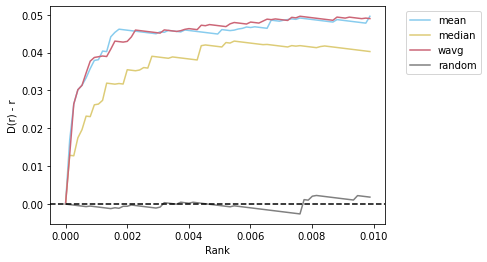

In [71]:
leadingEdge(inh_desc_drug_ranks, 'Pharos Inhibitors -- High to Low Sim', drug2target)

## Overlap with IDG target gene sets

In [11]:
import h5py

In [12]:
with h5py.File('../../consensus/cp_weightedavg_coeff_mat.gctx', 'r') as f_in:
  dex_mask = np.in1d(f_in['0/META/COL/id'].asstr()[:], ['dexamethasone'])
  dex_ind = f_in['0/META/COL/id'].asstr()[dex_mask].nonzero()[0]
  dex_consensus = f_in['0/DATA/0/matrix'][dex_ind, :]
  dex_consensus = pd.Series(
    dex_consensus[0],
    index=f_in['0/META/ROW/id'].asstr()[:]
  )

In [13]:
with h5py.File('../../consensus/xpr_weightedavg_coeff_mat.gctx', 'r') as f_in:
  mask = np.in1d(f_in['0/META/COL/id'].asstr()[:], ['NR1I2', 'NR0B1'])
  ind = f_in['0/META/COL/id'].asstr()[mask].nonzero()[0]
  consensus = pd.DataFrame(
    f_in['0/DATA/0/matrix'][ind, :],
    index=f_in['0/META/COL/id'].asstr()[mask],
    columns=f_in['0/META/ROW/id'].asstr()[:]
  )
  nr0b1_consensus = consensus.loc['NR0B1']
  nr1i2_consensus = consensus.loc['NR1I2']

In [14]:
def getEnrichrLibrary(library_name): 
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={library_name}'
    resp = requests.get(ENRICHR_URL)
    if not resp.ok: 
        raise Exception(f"Error downloading {library_name} library from Enrichr, please try again.")
    return resp.json()[library_name]['terms']

chea2022 = getEnrichrLibrary('ChEA_2022')

In [15]:
targets = ['NR3C1', 'NR0B1', 'NR1I2']
tf_gene_sets = {t: [] for t in targets}

for tf in chea2022.keys():
  geneset = []
  if any(t in tf for t in targets):
    if 'MLEC' not in tf and 'Wistar' not in tf:
      tf_gene_sets[tf.split(' ')[0]] += list(chea2022[tf].keys())

tf_gene_sets = {f"{t} Targets": set(tf_gene_sets[t]) for t in tf_gene_sets.keys()}

In [16]:
dex_up_genes = dex_consensus[dex_consensus > 0].sort_values(ascending=False).index.tolist()[:250]
dex_down_genes = dex_consensus[dex_consensus < 0].sort_values(ascending=True).index.tolist()[:250]

nr0b1_up_genes = nr0b1_consensus[nr0b1_consensus > 0].sort_values(ascending=False).index.tolist()[:250]
nr0b1_down_genes = nr0b1_consensus[nr0b1_consensus < 0].sort_values(ascending=True).index.tolist()[:250]

nr1i2_up_genes = nr1i2_consensus[nr1i2_consensus > 0].sort_values(ascending=False).index.tolist()[:250]
nr1i2_down_genes = nr1i2_consensus[nr1i2_consensus < 0].sort_values(ascending=True).index.tolist()[:250]

In [17]:
for tf in tf_gene_sets.keys(): 
  print(f"{tf}: {len(tf_gene_sets[tf])} genes")
print(f"Dex up genes: {len(dex_up_genes)}")
print(f"Dex down genes: {len(dex_down_genes)}")
print(f"NR0B1 up genes: {len(nr0b1_up_genes)}")
print(f"NR0B1 down genes: {len(nr0b1_down_genes)}")
print(f"NR1I2 up genes: {len(nr1i2_up_genes)}")
print(f"NR1I2 down genes: {len(nr1i2_down_genes)}")

NR3C1 Targets: 4042 genes
NR0B1 Targets: 1210 genes
NR1I2 Targets: 631 genes
Dex up genes: 250
Dex down genes: 250
NR0B1 up genes: 250
NR0B1 down genes: 250
NR1I2 up genes: 250
NR1I2 down genes: 250


In [30]:
color_map = {
  'NR3C1': '#44AA99',
  'NR0B1': '#DDCC77',
  'NR1I2': '#332288',
  'Dex Up Genes': '#88CCEE',
  'Dex Down Genes': '#AA4499',
  'NR0B1 Up Genes': '#88CCEE',
  'NR0B1 Down Genes': '#AA4499',
  'NR1I2 Up Genes': '#88CCEE',
  'NR1I2 Down Genes': '#AA4499'
}

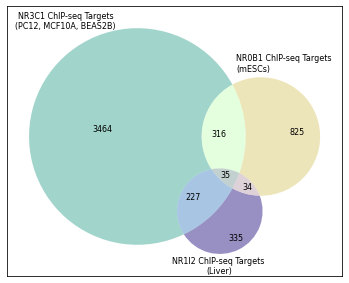

In [31]:
fig = plt.figure(figsize=(6,6))
vd = venn3(
  [
    tf_gene_sets['NR3C1 Targets'], 
    tf_gene_sets['NR0B1 Targets'], 
    tf_gene_sets['NR1I2 Targets']
  ],
  (
    'NR3C1 ChIP-seq Targets \n(PC12, MCF10A, BEAS2B)', 
    'NR0B1 ChIP-seq Targets \n(mESCs)', 
    'NR1I2 ChIP-seq Targets \n(Liver)'
  ),
  set_colors=(
    color_map['NR3C1'],
    color_map['NR0B1'],
    color_map['NR1I2']
  ),
  alpha=0.5
)

for text in vd.set_labels:
  text.set_fontsize(8)
for text in vd.subset_labels:
  text.set_fontsize(8)

# Adjust label for NR3C1 targets
lbl1 = vd.get_label_by_id("A")
x, y = lbl1.get_position()
lbl1.set_position((x+0.15, y))

# Adjust label for NR0B1 targets
lbl2 = vd.get_label_by_id("B")
x2, y2 = lbl2.get_position()
lbl2.set_position((x2-0.25, y2+0.03))

# Adjust label for NR1I2 targets
lbl2 = vd.get_label_by_id("C")
x2, y2 = lbl2.get_position()
lbl2.set_position((x2, y2+0.01))

plt.gca().set_facecolor('white')
plt.gca().set_axis_on()

fig.savefig("../../publicationfigs/Figure6.pdf", format='pdf', dpi=300)

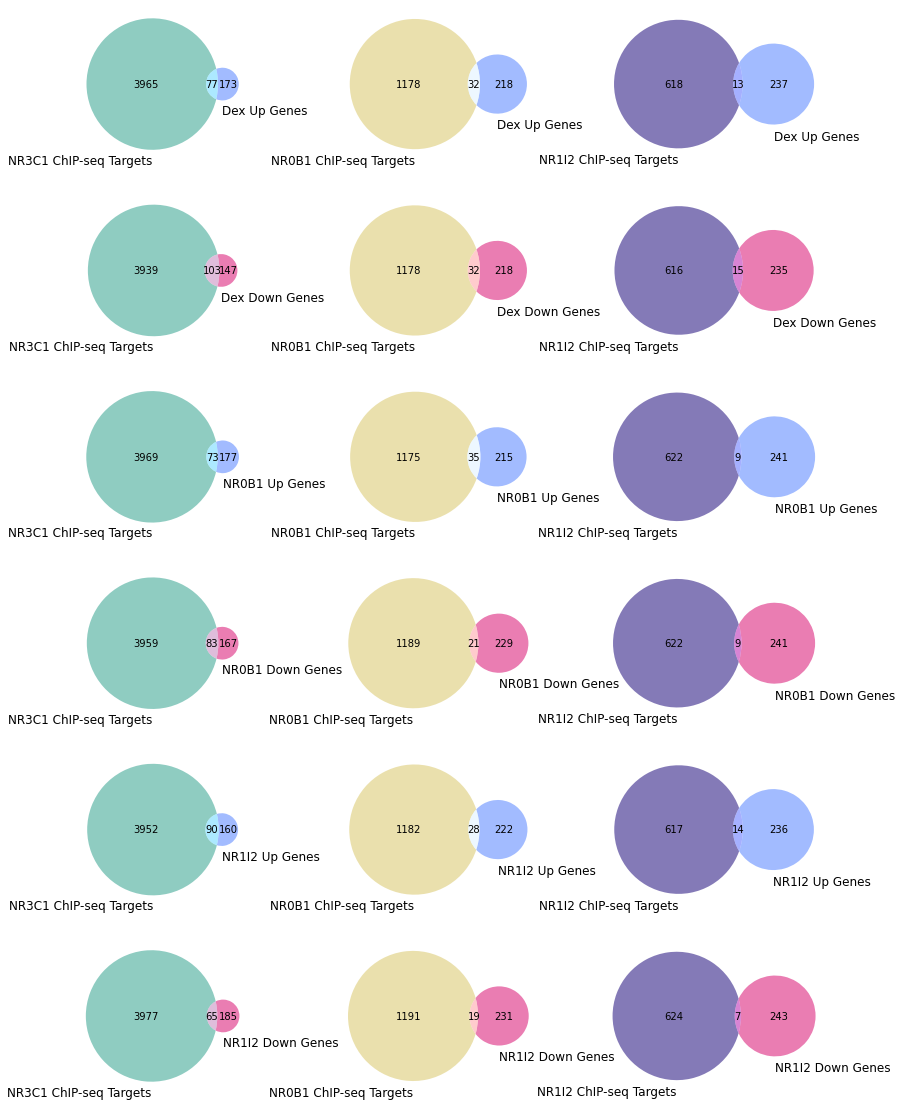

In [33]:
tf_dex_overlap = {}

fig, axs = plt.subplots(6,3, figsize=(14,20))
fig.set_facecolor('white')
c = 0
for tf in tf_gene_sets.keys(): 
  tf_dex_overlap[f"{tf} - Dex Up Genes"] = tf_gene_sets[tf].intersection(dex_up_genes)
  venn2(
    [tf_gene_sets[tf], set(dex_up_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'Dex Up Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#648FFF'),
    alpha=0.6,
    ax=axs[0][c]
  )
  tf_dex_overlap[f"{tf} - Dex Down Genes"] = tf_gene_sets[tf].intersection(dex_down_genes)
  venn2(
    [tf_gene_sets[tf], set(dex_down_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'Dex Down Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#DC267F'),
    alpha=0.6,
    ax=axs[1][c]
  )
  tf_dex_overlap[f"{tf} - NR0B1 Up Genes"] = tf_gene_sets[tf].intersection(nr0b1_up_genes)
  venn2(
    [tf_gene_sets[tf], set(nr0b1_up_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'NR0B1 Up Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#648FFF'),
    alpha=0.6,
    ax=axs[2][c]
  )
  tf_dex_overlap[f"{tf} - NR0B1 Down Genes"] = tf_gene_sets[tf].intersection(nr0b1_down_genes)
  venn2(
    [tf_gene_sets[tf], set(nr0b1_down_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'NR0B1 Down Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#DC267F'),
    alpha=0.6,
    ax=axs[3][c]
  )
  tf_dex_overlap[f"{tf} - NR1I2 Up Genes"] = tf_gene_sets[tf].intersection(nr1i2_up_genes)
  venn2(
    [tf_gene_sets[tf], set(nr1i2_up_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'NR1I2 Up Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#648FFF'),
    alpha=0.6,
    ax=axs[4][c]
  )
  tf_dex_overlap[f"{tf} - NR1I2 Down Genes"] = tf_gene_sets[tf].intersection(nr1i2_down_genes)
  venn2(
    [tf_gene_sets[tf], set(nr1i2_down_genes)],
    (tf.replace(' Targets', ' ChIP-seq Targets'), 'NR1I2 Down Genes'),
    set_colors=(color_map[tf.split(' Targets')[0]], '#DC267F'),
    alpha=0.6,
    ax=axs[5][c]
  )
  c += 1

fig.savefig("../../publicationfigs/Figure5.pdf", format='pdf', dpi=300)

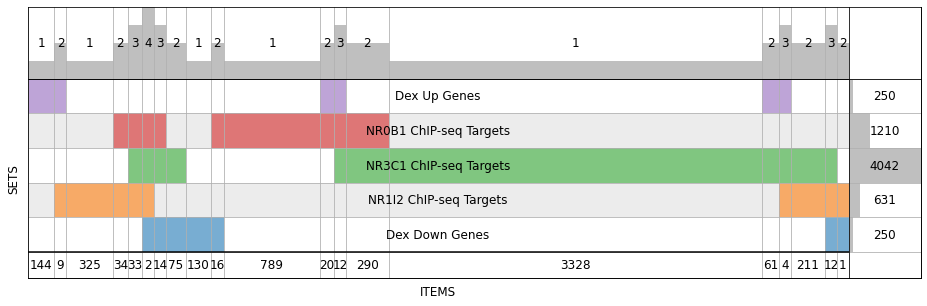

In [30]:
fig = plt.figure(figsize=(16, 5))
supervenn(
  [
    tf_gene_sets['NR3C1 Targets'],
    tf_gene_sets['NR0B1 Targets'],
    tf_gene_sets['NR1I2 Targets'],
    set(dex_up_genes),
    set(dex_down_genes)
  ],
  [
    'NR3C1 ChIP-seq Targets', 
    'NR0B1 ChIP-seq Targets', 
    'NR1I2 ChIP-seq Targets',
    'Dex Up Genes',
    'Dex Down Genes'
  ],
  chunks_ordering='minimize gaps',
  sets_ordering='minimize gaps',
  widths_minmax_ratio=0.03
)

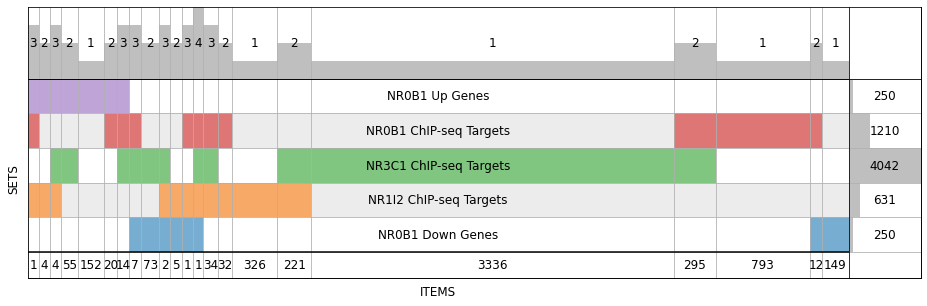

In [31]:
fig = plt.figure(figsize=(16, 5))
supervenn(
  [
    tf_gene_sets['NR3C1 Targets'],
    tf_gene_sets['NR0B1 Targets'],
    tf_gene_sets['NR1I2 Targets'],
    set(nr0b1_up_genes),
    set(nr0b1_down_genes)
  ],
  [
    'NR3C1 ChIP-seq Targets', 
    'NR0B1 ChIP-seq Targets', 
    'NR1I2 ChIP-seq Targets',
    'NR0B1 Up Genes',
    'NR0B1 Down Genes'
  ],
  chunks_ordering='minimize gaps',
  sets_ordering='minimize gaps',
  widths_minmax_ratio=0.03
)

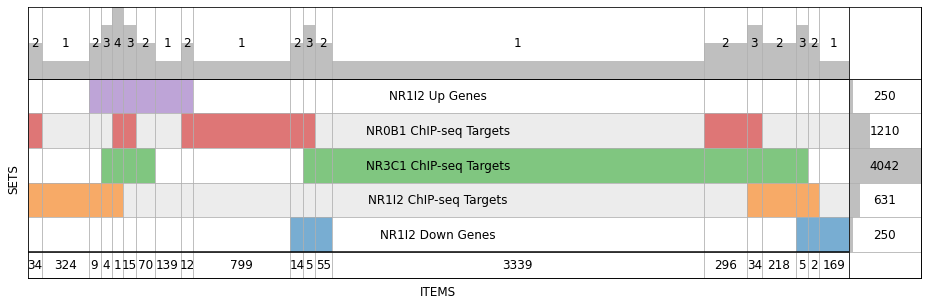

In [33]:
fig = plt.figure(figsize=(16, 5))
supervenn(
  [
    tf_gene_sets['NR3C1 Targets'],
    tf_gene_sets['NR0B1 Targets'],
    tf_gene_sets['NR1I2 Targets'],
    set(nr1i2_up_genes),
    set(nr1i2_down_genes)
  ],
  [
    'NR3C1 ChIP-seq Targets', 
    'NR0B1 ChIP-seq Targets', 
    'NR1I2 ChIP-seq Targets',
    'NR1I2 Up Genes',
    'NR1I2 Down Genes'
  ],
  chunks_ordering='minimize gaps',
  sets_ordering='minimize gaps',
  widths_minmax_ratio=0.03
)

In [34]:
# Dex down vs targets
print('Dex down')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(dex_down_genes))
# Dex up vs targets
print('Dex up')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(dex_up_genes))

# NR0B1 down vs targets
print('NR0B1 down')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(nr0b1_down_genes))
# NR0B1 up vs targets
print('NR0B1 up')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(nr0b1_up_genes))

# NR1I2 down vs targets
print('NR1I2 down')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(nr1i2_down_genes))
# NR1I2 up vs targets
print('NR1I2 up')
print(tf_gene_sets['NR0B1 Targets'].intersection(tf_gene_sets['NR3C1 Targets']).intersection(tf_gene_sets['NR1I2 Targets']).intersection(nr1i2_up_genes))


Dex down
{'NRP1', 'IL6ST'}
Dex up
set()
NR0B1 down
{'NFKBIA'}
NR0B1 up
set()
NR1I2 down
set()
NR1I2 up
{'FGF1'}


Overlap between all three target gene sets

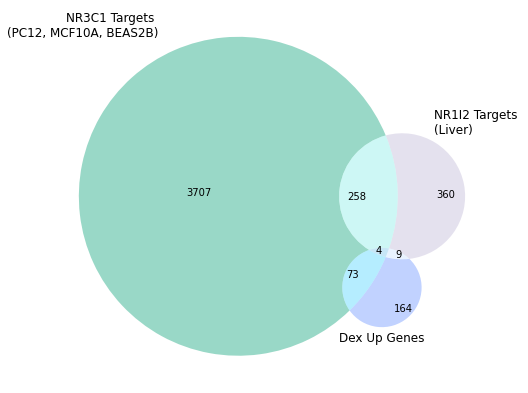

In [35]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
venn3(
  [
    tf_gene_sets['NR3C1 Targets'],
    tf_gene_sets['NR1I2 Targets'],
    set(dex_up_genes)
  ],
  (
    'NR3C1 Targets \n(PC12, MCF10A, BEAS2B)', 
    'NR1I2 Targets \n(Liver)',
    'Dex Up Genes'
  ),
  set_colors=(
    color_map['NR3C1'], 
    color_map['NR1I2'],
    color_map['Dex Up Genes']
  ),
  alpha=0.4
)